In [24]:
import itertools
import numpy as np
import random
import pandas as pd
import seaborn as sns
from scipy import  stats
from  sklearn.manifold import TSNE

In [6]:

class repertoire():
    # define a repertoire which is scale free
    def __init__(self,cell_number,somatic_hypermutation_rate,poliferation_form = 0,max_stimulation = 100, footstep=1.5):
        # initial cell number
        self.cell_number = cell_number 
        # initial BCR,TCR stimulating signal triggered by a random antigen should be gaussian distribution
        self.poliferation_factor = [abs(np.random.normal(loc=0,scale=1,size=None)) for i in range(cell_number)] 
        self.mutation_rate = somatic_hypermutation_rate

        self.clone_number = {str(i):1 for i in range(cell_number)}
        self.mutation_num = {str(i):0 for i in range(cell_number)}
        self.poliferation_form = poliferation_form
        self.footstep = footstep
        # max stimulating signal triggered by BCR,TCR
        self.max_stimulation=max_stimulation
        self._poliferation_probability = 0

    def cell_id_list(self):
        return [i for i in range(self.cell_number)]


    def cell_poliferation_probability(self):
        return [self.stimulation_to_poliferation(self.poliferation_factor[i])*self.clone_number[str(i)] for i in  range(self.cell_number)]
        # normalize probability each time after a new cell joins
        
    
    def stimulation_to_poliferation(self,i):
        # different formulation get similiar scale free power law distribution
        if self.poliferation_form ==0:
            return np.exp(i/10)
        if self.poliferation_form ==1:
            return np.exp(i*0.3)
        if self.poliferation_form ==2:
            return np.exp(i)
        elif self.poliferation_form == 3:
            return np.power(10,i/50)
        elif self.poliferation_form == 4:
            return np.power(10,i/100)*np.exp(i/10)
        else:
            return np.power(10,i)*np.exp(5*i)
        
    def proliferate(self,poliferation_number):
        # proliferation
        for cell_i in range(poliferation_number):
            probability_index = random.choices(self.cell_id_list(), weights=self.cell_poliferation_probability(), k=1)[0]
            # choose a clone to attach
            
            # accroading to real world data, previous research and structure of BCR, 

            # it is nearly impossible to get a BCR with mutation number > 50

            # so we set cells with big mutation numbers have lower mutation rate
            if self.mutation_num[str(probability_index)]>10:
                real_mutation_rate = self.mutation_rate*(50-self.mutation_num[str(probability_index)])/50
            elif self.mutation_num[str(probability_index)] >=50:
                # proliferate without mutation
                self.clone_number[str(probability_index)] +=1
                continue
            else:
                real_mutation_rate=self.mutation_rate

            if random.random() < real_mutation_rate:
                # SHM or proliferation
                parent_mutation_num = self.mutation_num[str(probability_index)]
                self.add_new_cell(self.poliferation_factor[probability_index], parent_mutation_num)
            else:
                self.clone_number[str(probability_index)] +=1
                
    def add_new_cell(self,parent_poliferation_factor, parent_mutation_num):
        # inherit poliferation_factor from parent cell
        new_poliferation_factor = max(np.random.normal(loc=parent_poliferation_factor,scale=self.footstep,size=None),0)
        if new_poliferation_factor > self.max_stimulation:
            # mutation will not contribute to poliferation speed after reaching max stimulation
            new_poliferation_factor = self.max_stimulation
        cell_id = max(self.cell_id_list())+1
        self.cell_number = self.cell_number + 1
        self.poliferation_factor.append(new_poliferation_factor)
        self.clone_number.update({
            str(cell_id):1
        })
        self.mutation_num.update({
            str(cell_id):parent_mutation_num+1
        })


In [ ]:
# define the initial status of repertoire
simulate_repertoire = repertoire(10000,0,4,100,1.5)
# proliferate to a certain total cell number
simulate_repertoire.proliferate(10000000)

In [ ]:
# check cell number in each clone:
simulate_repertoire.clone_number.values()
# check mutation number for each clone:
simulate_repertoire.mutation_num.values()
# check clone id:
simulate_repertoire.cell_id_list()

In [20]:
# distance calculation and visualization
# all info in example data are from BLAST result
# each line in the csv file represent a kind of BCR or TCR seq
# UMI are added to the cDNA in the RT-PCR step
# seq with same UMI, V, J, CDR3 length, and levenshtein distance < 3bp in CDR3 are considered as same seq
# seq with same BCR or TCR seq but different UMI are from same clone and clone size are counted in "clone_size" column
example_data1 = pd.read_csv('example_data_1.csv')
example_data2 = pd.read_csv('example_data_2.csv')
example_data3 = pd.read_csv('example_data_3.csv')
data_list = [example_data1,example_data2,example_data3]
for datai in data_list:
    # calculate mutation number from nt mutation list
    datai['nt_mutation_number'] = datai['nt_mutations'].apply(lambda x:x.count('", "'))

    # calculate clone weights from nt mutation number
    datai['weights'] = datai['nt_mutation_number'].apply(lambda x:np.power(x,2)+0.1)

# build distance matrix from sample wasserstein distance
distance_matrix = [
    [stats.wasserstein_distance(
                i['clone_size'],
                j['clone_size'],
                i['weights'],
                j['weights'],
        ) for i in data_list
    ] for j in data_list
    ]


<Axes: xlabel='x', ylabel='y'>

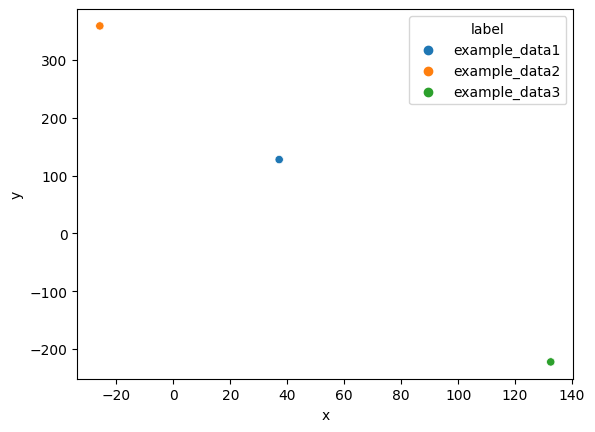

In [31]:
# Visualization by TSNE
tsne = TSNE(n_components=2,metric='precomputed',perplexity=1,init='random',n_iter=100000,min_grad_norm=1e-7)
coordinate = tsne.fit_transform(pd.DataFrame(distance_matrix))
draw = pd.DataFrame(coordinate,columns=['x','y'])
draw['label'] = ['example_data1','example_data2','example_data3']
sns.scatterplot(
    draw,
    x='x',
    y='y',
    hue='label'
)

In [28]:
draw

,x,y
0,218.929108,26.215338
1,96.839470,79.271584
2,403.792694,-54.120461
